In [35]:
import numpy as np
import tensorflow_probability as tfp
import pandas as pd
from bisect import bisect_left
from scipy import special
from scipy.special import erf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy.linalg import inv
import tensorflow as tf
import scipy.linalg
import scipy.spatial
import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
from scipy.stats.distributions import chi2
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from gpflow.utilities import print_summary, positive
np.set_printoptions(suppress=True)
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import pymc3

from utilities import (trapezoidal_area, compute_prior_hyperparameters, predict_in_observations, fit_Hand, y_exp_Hand, y_exp,  find_nearest, K_log, K_multiplicative)

f64 = gpflow.utilities.to_default_float

## Load the data 

In [36]:
df = pd.read_csv('../data/GrecoSimulatedData.csv', sep=';')
df = df.sort_values(by=['Dose1','Dose2'])

In [37]:
## Extract individual doses 

In [38]:
Effect = df['Response'].values.reshape(-1,1).copy()
Dose_A = df['Dose1'].values.astype(float).copy()
Dose_B = df['Dose2'].values.astype(float).copy()
Dose_AB = np.concatenate((Dose_A.reshape(-1,1), Dose_B.reshape(-1,1)), axis=1)

Effect_B = df[df['Dose1'] == 0]['Response'].to_numpy().reshape(-1,1).astype(float)
Effect_A = df[df['Dose2'] == 0]['Response'].to_numpy().reshape(-1,1).astype(float)
Dose_A = df[df['Dose2']==0]['Dose1'].to_numpy().reshape(-1,1).astype(float)
Dose_B = df[df['Dose1']==0]['Dose2'].to_numpy().reshape(-1,1).astype(float)


In [39]:
# hyperparameters of the priors
A_max  = np.max(Dose_A)
B_max = np.max(Dose_B)

alphaA, betaA = compute_prior_hyperparameters(A_max, 0.1*A_max)
alphaB, betaB = compute_prior_hyperparameters(B_max, 0.1*B_max)

eff_max_a = np.max(Effect_A)
eff_max_b = np.max(Effect_B)
eff_max = np.max([eff_max_a, eff_max_b])

alpha_var, beta_var = compute_prior_hyperparameters(2.5*eff_max, 0.1*eff_max)


In [40]:
data = pd.concat([pd.DataFrame(Dose_AB), pd.DataFrame(Effect)], axis=1)
data.columns = ['Dose_A', 'Dose_B', 'Effect']

X1 = data[data['Dose_B']==0]['Dose_A'].to_numpy().reshape(-1,1).astype(float)
Y1 = data[data['Dose_B']==0]['Effect'].to_numpy().reshape(-1,1).astype(float)

X2 = data[data['Dose_A']==0]['Dose_B'].to_numpy().reshape(-1,1).astype(float)
Y2 = data[data['Dose_A']==0]['Effect'].to_numpy().reshape(-1,1).astype(float)

Dose_A = data[data['Dose_B']==0]['Dose_A'].to_numpy().reshape(-1,1).astype(float)
Effect_A = data[data['Dose_B']==0]['Effect'].to_numpy().reshape(-1,1).astype(float)

Dose_B = data[data['Dose_A']==0]['Dose_B'].to_numpy().reshape(-1,1).astype(float)
Effect_B = data[data['Dose_A']==0]['Effect'].to_numpy().reshape(-1,1).astype(float)

In [41]:
[l1_init, l2_init] = np.meshgrid(np.linspace(0.01, 2.0, 10), np.linspace(0.01,  2.0, 10))
l1_init = l1_init.reshape(-1,1)
l2_init = l2_init.reshape(-1,1)
Lik_null = np.zeros((100,1))
Lik_full = np.zeros((100,1))

prior_lengthscale_da = tfp.distributions.Gamma(np.float64(alphaA), np.float64(betaA))
prior_lengthscale_db = tfp.distributions.Gamma(np.float64(alphaB), np.float64(betaB))
prior_variance_da = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))
prior_variance_likelihood = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))

for i in range(1,100):
    try:
        init_lengthscale_da = l1_init[i,0]
        init_lengthscale_db = l2_init[i,0]
        init_variance = 1.0
        init_likelihood_variance = 0.01

        k_full = K_multiplicative()
        m_full = gpflow.models.GPR(data=(Dose_AB, Effect), kernel=k_full,  mean_function=None)
        m_full.likelihood.variance.assign(0.01)
        #set_trainable(m_full.likelihood.variance, False)
        m_full.kernel.lengthscale_da.assign(init_lengthscale_da)
        m_full.kernel.lengthscale_db.assign(init_lengthscale_db)
        # priors
        m_full.kernel.lengthscale_da.prior = prior_lengthscale_da
        m_full.kernel.lengthscale_db.prior = prior_lengthscale_db
        m_full.kernel.variance_da.prior = prior_variance_da
        m_full.likelihood.variance.prior = prior_variance_likelihood
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(m_full.training_loss,
                                m_full.trainable_variables,method='BFGS',
                                options=dict(maxiter=100))
        #print_summary(m_full)
        Lik_full[i,0] = np.asarray(m_full.training_loss())
    except:
        Lik_full[i,0] = 'NaN'
        print('Cholesky was not successful')

index = np.where(Lik_full == np.nanmin(Lik_full))[0][0]

In [42]:
index = np.where(Lik_full == np.nanmin(Lik_full))[0][0]

init_lengthscale_da = l1_init[index,0]
init_lengthscale_db = l2_init[index,0]

init_likelihood_variance = 0.01

k_full = K_multiplicative()
m_full = gpflow.models.GPR(data=(Dose_AB, Effect), kernel=k_full,  mean_function=None)
m_full.likelihood.variance.assign(init_likelihood_variance)
#set_trainable(m_full.likelihood.variance, False)
m_full.kernel.lengthscale_da.assign(init_lengthscale_da)
m_full.kernel.lengthscale_db.assign(init_lengthscale_db)
m_full.kernel.variance_da.assign(init_variance)
#priors
m_full.kernel.lengthscale_da.prior = prior_lengthscale_da
m_full.kernel.lengthscale_db.prior = prior_lengthscale_db
m_full.kernel.variance_da.prior = prior_variance_da
m_full.likelihood.variance.prior = prior_variance_likelihood
#m_null.likelihood.variance.trainable = False
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_full.training_loss,
                    m_full.trainable_variables, method='BFGS',
                    options=dict(maxiter=1000))
print_summary(m_full)


╒═══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                      │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ GPR.kernel.variance_da    │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 289.179   │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscale_da │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  44.0697  │
├───────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ GPR.kernel.lengthscale_db │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │   1.77253 │
├───────────────────────────┼───────────┼──────────────────┼────

In [43]:
num_predict = 2000
#[Xi, Xj] = np.meshgrid(X1, X2)
[Xi, Xj] = np.meshgrid(np.linspace(np.min(Dose_A), np.max(Dose_A), num_predict), np.linspace(np.min(Dose_B), np.max(Dose_B), num_predict))
X2 = Dose_AB.copy()

# We need to augument our test space to be a list of coordinates for input to the GP
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean and covariance of the GP fit at the test locations
mean2_full, Cov2_full = m_full.predict_f(Xnew2)

mean2_full = np.asarray(mean2_full)
Cov2_full = np.asarray(Cov2_full)

mean_full_est = pd.DataFrame(mean2_full.reshape(Xi.shape))
Cov_full_est = pd.DataFrame(Cov2_full.reshape(Xi.shape))


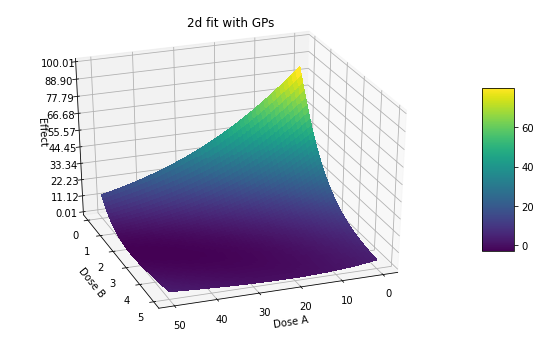

In [44]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(Xi, Xj, mean2_full.reshape(Xi.shape), cmap=cm.viridis,
                       linewidth=0, antialiased=False)

Cov_full_est = pd.DataFrame(Cov2_full.reshape(Xi.shape))

plt.title("2d fit with GPs")
# Customize the z axis.
ax.set_zlim(0.01, 100.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('Dose A')
ax.set_ylabel('Dose B')
ax.set_zlabel('Effect')
ax.view_init(30, 70)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('Greco'+'JointFit'+'.png')

In [45]:
xx_A = np.linspace(np.min(Dose_A), np.max(Dose_A),  num_predict).reshape(num_predict, 1)
xx_B = np.linspace(np.min(Dose_B), np.max(Dose_B),  num_predict).reshape( num_predict, 1)


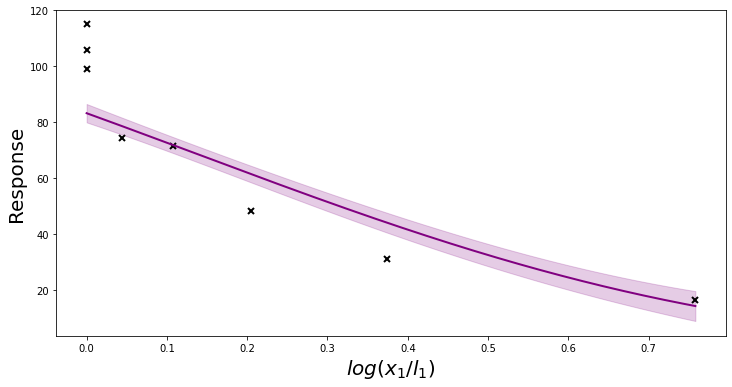

In [46]:
## plot
plt.figure(figsize=(12, 6))
plt.plot(np.log(Dose_A/m_full.kernel.lengthscale_da.value()+1), Effect_A, "kx", mew=2)
plt.plot(np.log(xx_A/m_full.kernel.lengthscale_da.value()+1), mean_full_est.loc[0],"C0", lw=2, color='purple')
plt.fill_between(
    np.log(xx_A[:, 0]/m_full.kernel.lengthscale_da.value()+1),
    mean_full_est.loc[0] - 1.96 * np.sqrt(Cov_full_est.loc[0]),
    mean_full_est.loc[0] + 1.96 * np.sqrt( Cov_full_est.loc[0]),
    color="purple",
    alpha=0.2
)
plt.ylabel('Response', fontsize=20)
plt.xlabel('$log(x_1/l_1)$', fontsize=20)
plt.show()

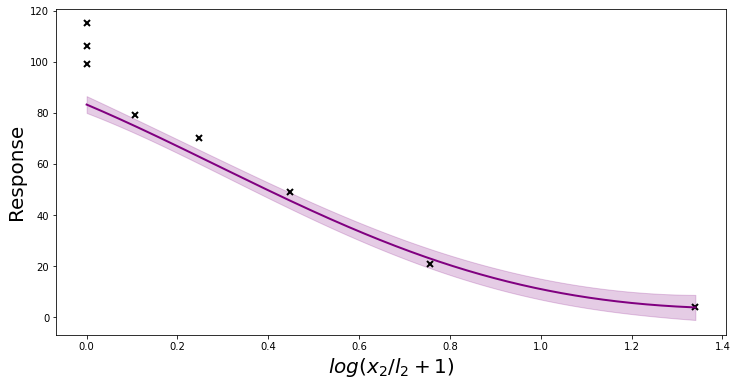

In [47]:
## plot
plt.figure(figsize=(12, 6))
plt.plot(np.log(Dose_B/m_full.kernel.lengthscale_db.value()+1), Effect_B, "kx", mew=2)
plt.plot(np.log(xx_B/m_full.kernel.lengthscale_db.value()+1), mean_full_est.iloc[:,0],"C0", lw=2, color='purple')
plt.fill_between(
    np.log(xx_B[:, 0]/m_full.kernel.lengthscale_db.value()+1),
    mean_full_est.iloc[:,0] - 1.96 * np.sqrt(Cov_full_est.iloc[:,0]),
    mean_full_est.iloc[:,0] + 1.96 * np.sqrt( Cov_full_est.iloc[:,0]),
    color="purple",
    alpha=0.2
)
plt.ylabel('Response', fontsize=20)
plt.xlabel('$log(x_2/l_2+1)$', fontsize=20)
plt.show()

In [29]:
alphaA, betaA = compute_prior_hyperparameters(A_max, 0.1*A_max)
alphaB, betaB = compute_prior_hyperparameters(B_max, 0.1*B_max)

eff_max_a = np.max(Effect_A)
eff_max_b = np.max(Effect_B)
eff_max = np.max([eff_max_a, eff_max_b])

alpha_var, beta_var = compute_prior_hyperparameters(eff_max, 0.1*eff_max)

prior_lengthscale_da = tfp.distributions.Gamma(np.float64(alphaA), np.float64(betaA))
prior_lengthscale_db = tfp.distributions.Gamma(np.float64(alphaB), np.float64(betaB))
prior_variance_da = tfp.distributions.Gamma(np.float64(alpha_var), np.float64(beta_var))
prior_variance_likelihood = tfp.distributions.Gamma(np.float64(2.0), np.float64(2.0))

In [30]:
for i in range(1,100):
    try:
        init_lengthscale_da = l1_init[i,0]
        init_lengthscale_db = l2_init[i,0]
        init_variance = 1.0
        init_likelihood_variance = 0.01

        k1 = gpflow.kernels.RBF(active_dims=[0])
        k2 = gpflow.kernels.RBF(active_dims=[1])
        k_full = k1 * k2
        m_rbf = gpflow.models.GPR(data=(Dose_AB, Effect), kernel=k_full,  mean_function=None)
        m_rbf.likelihood.variance.assign(0.01)
        #set_trainable(m_full.likelihood.variance, False)
        m_rbf.kernel.kernels[0].lengthscales.assign(init_lengthscale_da)
        m_rbf.kernel.kernels[1].lengthscales.assign(init_lengthscale_db)
        # priors
        m_rbf.kernel.kernels[0].lengthscales.prior = prior_lengthscale_da
        m_rbf.kernel.kernels[1].lengthscales.prior = prior_lengthscale_db
        m_rbf.kernel.kernels[0].variance.prior = prior_variance_da
        m_rbf.kernel.kernels[1].variance.prior = prior_variance_da
        m_rbf.likelihood.variance.prior = prior_variance_likelihood
        opt = gpflow.optimizers.Scipy()
        opt_logs = opt.minimize(m_rbf.training_loss,
                                m_rbf.trainable_variables,method='BFGS',
                                options=dict(maxiter=100))
        #print_summary(m_full)
        Lik_full[i,0] = np.asarray(m_full.training_loss())
    except:
        Lik_full[i,0] = 'NaN'
        print('Cholesky was not successful')

In [31]:
index = np.where(Lik_full == np.nanmin(Lik_full))[0][0]

init_lengthscale_da = l1_init[index,0]
init_lengthscale_db = l2_init[index,0]

init_likelihood_variance = 0.01
k1 = gpflow.kernels.RBF(active_dims=[0])
k2 = gpflow.kernels.RBF(active_dims=[1])
k_full = k1 * k2

m_rbf = gpflow.models.GPR(data=(Dose_AB, Effect), kernel=k_full,  mean_function=None)
m_rbf.likelihood.variance.assign(init_likelihood_variance)
#set_trainable(m_full.likelihood.variance, False)
m_rbf.kernel.kernels[0].lengthscales.assign(init_lengthscale_da)
m_rbf.kernel.kernels[1].lengthscales.assign(init_lengthscale_db)
# priors
m_rbf.kernel.kernels[0].lengthscales.prior = prior_lengthscale_da
m_rbf.kernel.kernels[1].lengthscales.prior = prior_lengthscale_db
m_rbf.kernel.kernels[0].variance.prior = prior_variance_da
m_rbf.kernel.kernels[1].variance.prior = prior_variance_da
m_rbf.likelihood.variance.prior = prior_variance_likelihood
m_rbf.likelihood.variance.prior = prior_variance_likelihood
#m_null.likelihood.variance.trainable = False
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(m_rbf.training_loss,
                    m_rbf.trainable_variables, method='BFGS',
                    options=dict(maxiter=1000))
print_summary(m_rbf)

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │    value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 115.806  │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │  46.7809 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │ Gamma   │ True        │ ()      │ float64 │ 115.806  │


In [32]:
num_predict = 2000
#[Xi, Xj] = np.meshgrid(X1, X2)
[Xi, Xj] = np.meshgrid(np.linspace(np.min(Dose_A), np.max(Dose_A), num_predict), np.linspace(np.min(Dose_B), np.max(Dose_B), num_predict))
X2 = Dose_AB.copy()

# We need to augument our test space to be a list of coordinates for input to the GP
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean and covariance of the GP fit at the test locations
mean2_rbf, Cov2_rbf = m_rbf.predict_f(Xnew2)

mean2_rbf = np.asarray(mean2_rbf)
Cov2_rbf = np.asarray(Cov2_rbf)

mean_rbf_est = pd.DataFrame(mean2_rbf.reshape(Xi.shape))
Cov_rbf_est = pd.DataFrame(Cov2_rbf.reshape(Xi.shape))


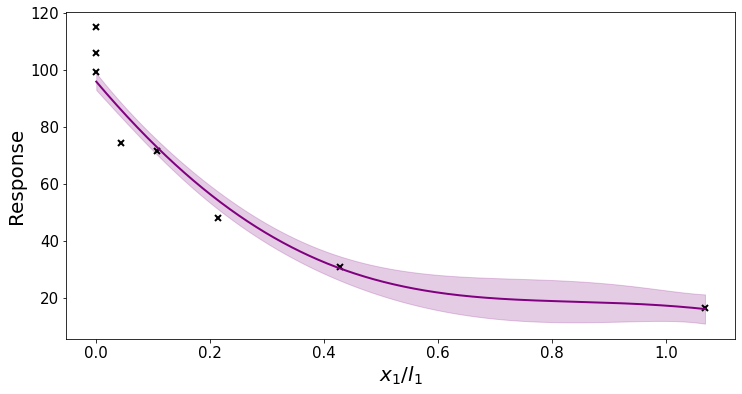

In [33]:
Cov_rbf_est = pd.DataFrame(Cov2_rbf.reshape(Xi.shape))

xx_A = np.linspace(np.min(Dose_A), np.max(Dose_A),  num_predict).reshape(num_predict, 1)
xx_B = np.linspace(np.min(Dose_B), np.max(Dose_B),  num_predict).reshape( num_predict, 1)
## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_A/m_rbf.kernel.kernels[0].lengthscales.value(), Effect_A, "kx", mew=2)
plt.plot(xx_A/m_rbf.kernel.kernels[0].lengthscales.value(), mean_rbf_est.loc[0],"C0", lw=2, color='purple')
plt.fill_between(
    xx_A[:, 0]/m_rbf.kernel.kernels[0].lengthscales.value(),
    mean_rbf_est.loc[0] - 1.96 * np.sqrt(Cov_rbf_est.loc[0]),
    mean_rbf_est.loc[0] + 1.96 * np.sqrt( Cov_rbf_est.loc[0]),
    color="purple",
    alpha=0.2
)
#plt.title('Dose-response curve')
plt.ylabel('Response', fontsize=20)
plt.xlabel('$x_1/l_1$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

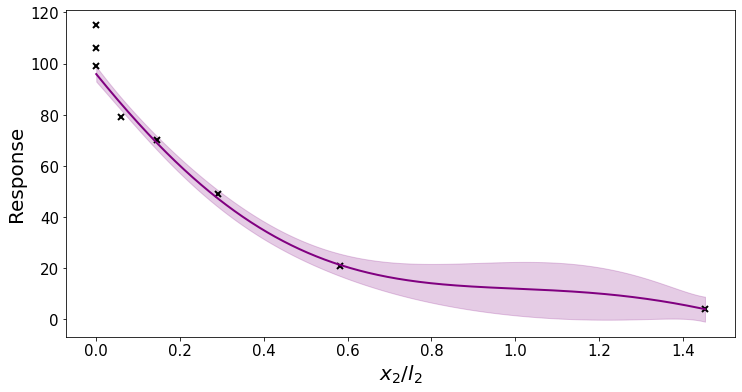

In [34]:
## plot
plt.figure(figsize=(12, 6))
plt.plot(Dose_B/m_rbf.kernel.kernels[1].lengthscales.value(), Effect_B, "kx", mew=2)
plt.plot(xx_B/m_rbf.kernel.kernels[1].lengthscales.value(), mean_rbf_est.iloc[:,0],"C0", lw=2, color='purple')
plt.fill_between(
    xx_B[:, 0]/m_rbf.kernel.kernels[1].lengthscales.value(),
    mean_rbf_est.iloc[:,0] - 1.96 * np.sqrt(Cov_rbf_est.iloc[:,0]),
    mean_rbf_est.iloc[:,0] + 1.96 * np.sqrt(Cov_rbf_est.iloc[:,0]),
    color="purple",
    alpha=0.2
)
plt.ylabel('Response', fontsize=20)
plt.xlabel('$x_2/l_2$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('Greco'+'DrugB_rbf'+'.png')
